Imports

In [1]:
# Raw Package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# Data Source
import yfinance as yf

# Data viz
import plotly.graph_objs as go


handed out code to download the data:

In [2]:
# Get Bitcoin data
data = yf.download(tickers='BTC-USD', period='5y', interval='1d')

# declare figure
fig = go.Figure()

# Candlestick
fig.add_trace(go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'], name='market data'))
                             

# Add titles
fig.update_layout(
    title='Bitcoin live share price evolution',
    yaxis_title='Bitcoin Price (kUS Dollars)')

# X-Axes
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label="15m", step="minute", stepmode="backward"),
            dict(count=45, label="45m", step="minute", stepmode="backward"),
            dict(count=1, label="HTD", step="hour", stepmode="todate"),
            dict(count=6, label="6h", step="hour", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()


[*********************100%***********************]  1 of 1 completed


Data processing:

In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-02-28,1180.719971,1193.250000,1171.819946,1179.969971,1179.969971,184956000
2017-03-01,1180.040039,1222.500000,1179.689941,1222.500000,1222.500000,229056992
2017-03-02,1224.680054,1262.130005,1215.619995,1251.010010,1251.010010,368275008
2017-03-03,1250.709961,1280.310059,1250.709961,1274.989990,1274.989990,315739008
2017-03-04,1277.430054,1279.400024,1230.510010,1255.150024,1255.150024,183270000
...,...,...,...,...,...,...
2022-02-24,37278.566406,38968.839844,34459.218750,38332.609375,38332.609375,46383802093
2022-02-25,38333.746094,39630.324219,38111.343750,39214.218750,39214.218750,26545599159
2022-02-26,39213.082031,40005.347656,38702.535156,39105.148438,39105.148438,17467554129


In [4]:
data.shape

(1827, 6)

Checking for null values and NaN

In [5]:
data.isnull().values.any()


False

Make training and test data, removing adj close. Splitting the data per year into 4 years of training and 1 year of testing

In [6]:
train = data.iloc[:(1462)]
test = data.iloc[(1462):]

training = train.drop(['Adj Close'], axis = 1)
testing = test.drop(['Adj Close'], axis = 1)
print(training.shape, testing.shape)

(1462, 5) (365, 5)


Normalizing data

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
training_sc = scaler.fit_transform(training)
testing_sc = scaler.fit_transform(testing)

Plotting the closing price of Bitcoin for all four years

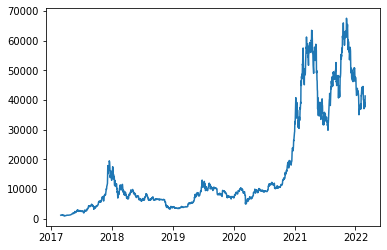

In [8]:
plt.plot(data["Close"])
plt.show()

Sequencing: Splitting the data into sequences to give as input in the LSTM model. 

In [9]:
x_train = [] 
y_train = []


for i in range(30, training_sc.shape[0]):
    x_train.append(training_sc[i-30:i,3])
    y_train.append(training_sc[i,3])
x_train, y_train = np.array(x_train), np.array(y_train)

x_test = []
y_test = []
for i in range(30,testing_sc.shape[0]):
    x_test.append(testing_sc[i-30:i,3])
    y_test.append(testing_sc[i,3])
x_test, y_test = np.array(x_test), np.array(y_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape




((1432, 30), (1432,), (335, 30), (335,))

Setup of the LSTM network

In [10]:

model = keras.Sequential([
    keras.layers.LSTM(50, input_shape=(30,1), return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Compile the model

In [11]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss = "mse", metrics = keras.metrics.RootMeanSquaredError())

Train the model

In [12]:
model.fit(x_train, y_train, epochs = 100, batch_size=50)

Epoch 1/100
29/29 [==============================] - 5s 32ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558
Epoch 2/100
29/29 [==============================] - 1s 35ms/step - loss: 0.0176 - root_mean_squared_error: 0.1328
Epoch 3/100
29/29 [==============================] - 1s 33ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278
Epoch 4/100
29/29 [==============================] - 1s 34ms/step - loss: 0.0156 - root_mean_squared_error: 0.1248
Epoch 5/100
29/29 [==============================] - 1s 33ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197
Epoch 6/100
29/29 [==============================] - 1s 40ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162
Epoch 7/100
29/29 [==============================] - 1s 43ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148
Epoch 8/100
29/29 [==============================] - 1s 37ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110
Epoch 9/100
29/29 [==============================] - 1s 35ms/step - loss: 0.0111

Using the model on the test data

In [17]:
predicted_prices = model.predict(x_test)

Retaining the values from the scaled values

In [14]:
predicted_prices = predicted_prices[:,0]
scale_value = 1 / (scaler.scale_[3])
predicted_prices_rescaled = predicted_prices * scale_value
y_test_rescaled = y_test * scale_value

Plotting the result of the trained model againts the actual price

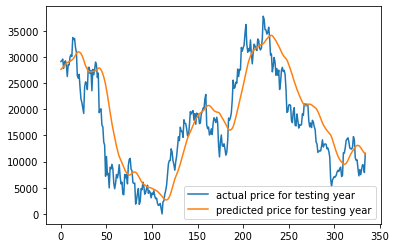

In [15]:
plt.plot(y_test_rescaled, label="actual price for testing year")
plt.plot(predicted_prices_rescaled, label="predicted price for testing year")
plt.legend()
plt.show()
